In [1]:
import numpy as np
import importlib
import util as uti
import matplotlib.pyplot as plt
importlib.reload(uti)

# import math lib
from math import pi

# import Qiskit
from qiskit import Aer, IBMQ, execute, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import GroverOperator
from qiskit_machine_learning.circuit.library import RawFeatureVector

# import basic plot tools
#import qiskit.visualization as vis
from qiskit.visualization import plot_histogram
%matplotlib inline

/home/kinga/.local/lib/python3.6/site-packages/qiskit/__init__.py:66: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of qiskit-terra 0.17.0. Support for running Qiskit with Python 3.6 will be removed in qiskit-terra 0.20.0.
  DeprecationWarning,


# overlap calculation

# state preparation

In [2]:
def calc_amplitudes(v):
    ''' amplitude encoding of raw input vector v '''
    ''' TODO: compare with qiskit's RawFeatureVector '''
    return v / np.linalg.norm(v)

In [3]:
def prepare_swap_state_amplitudes(a, b):
    
    # normalize to unity
    a_q = calc_amplitudes(a)
    b_q = calc_amplitudes(b)
    
    # first state psi 1/sqrt(2) (|0,a> + \1,b>) = R4
    psi = np.hstack([a_q, b_q]) * (1/np.sqrt(2))
    a_norm = np.linalg.norm(a)
    b_norm = np.linalg.norm(b)
    Z = a_norm**2 + b_norm**2
    # second state phi with identity
    phi = np.array([a_norm, -b_norm]) * (1/np.sqrt(Z))
    
    return psi, phi, Z

# swap test

In [77]:
# routine that expresses overlap of phi and psi <phi|psi>
def swap_test(phi_amp, psi_amp):
    
    backend = Aer.get_backend('aer_simulator_statevector')

    n = 1 + 2 + 1 # 1 control qubit + 2 qubits for input vectors + 1 qubit for check vector
    qc = QuantumCircuit(n, 1, name="swap_test")
    
    # first control qubit in default |0> 
    #|001> -> plot
    #qc.x(0)
    # load data
    qc.initialize(phi_amp, 3) # second qubit = 1/sqrt(Z) * (|a||0> + |b||1> )
    qc.initialize(psi_amp, [1,2]) # third & fourth qubit = 1/sqrt(2) * (|0,a> + |1,b>)
    
    # build swap test
    qc.h(0)
    qc.cswap(3, 2, 0) # perform test on v1 ancilla alone
    qc.h(0)
    
    # measure
    qc.measure(0,0)
   
    shots = 1024
    qobj = assemble(qc, backend)
    results = backend.run(qobj).result()
    answer = results.get_counts()

    return qc, answer

# input data

In [5]:
a = np.array([10., 1])
b = np.array([-2., 40])

In [6]:
psi, phi, Z = prepare_swap_state_amplitudes(a, b)

In [7]:
print(psi)
print(phi)
print(Z)

[ 0.70359754  0.07035975 -0.03531123  0.70622455]
[ 0.24338763 -0.9699291 ]
1705.0000000000002


In [8]:
backend = Aer.get_backend('qasm_simulator')
# create circuit with n qubits and one classical bit for measurement
# qubits: first: ancilla, second: input vector, third: cluster center
#(for latent space in R^2: 1 (ancilla) + 1 (x1,x2 coords of input) + 1 (x1,x2 coords of cluster))
n = int((len(psi)+len(phi))/2)+1
print('n ', n)
qc = QuantumCircuit(n, 1, name="swap_test")

# load data
# control qubit default 0
# first and second qubits init to psi (tensorproduct of ancilla qubit and vector value)
qc.initialize(psi, [1,2])
# third qubit init to phi
qc.initialize(phi, 3)
qc.barrier()
# apply hadamard to control
qc.h(0)
# swap psi ancilla with phi
qc.cswap(0,1,3)
# apply second hadamard
qc.h(0)
# measure control qubit
qc.measure(0,0)
qc.draw()

n  4


░ ┌───┐   ┌───┐┌─┐
q_0: ──────────────────────────────────────────────────░─┤ H ├─■─┤ H ├┤M├
     ┌───────────────────────────────────────────────┐ ░ └───┘ │ └───┘└╥┘
q_1: ┤0                                              ├─░───────X───────╫─
     │  Initialize(0.7036,0.07036,-0.035311,0.70622) │ ░       │       ║ 
q_2: ┤1                                              ├─░───────┼───────╫─
     └────────┬──────────────────────────────┬───────┘ ░       │       ║ 
q_3: ─────────┤ Initialize(0.24339,-0.96993) ├─────────░───────X───────╫─
              └──────────────────────────────┘         ░               ║ 
c: 1/══════════════════════════════════════════════════════════════════╩═
                                                                       0

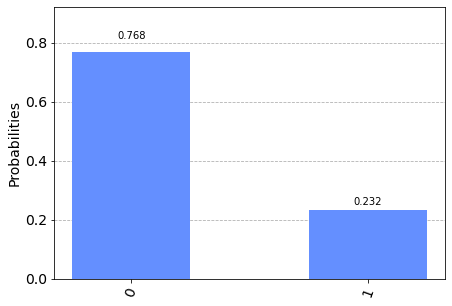

In [9]:
shots = 1024
qobj = assemble(qc, backend)
results = backend.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

In [10]:
# basic swap test directly on quantum states that are rotated against each other
def swap_test_basic(rotate_a, rotate_b):
    
    backend = Aer.get_backend('qasm_simulator')
    # create circuit with n qubits and one classical bit for measurement
    # qubits: first: ancilla, second: input vector, third: cluster center
    #(for latent space in R^2: 1 (ancilla) + 1 (x1,x2 coords of input) + 1 (x1,x2 coords of cluster))
    n = 2+1
    qc = QuantumCircuit(n, 1, name="swap_test")

    # control qubit default 0
    # rotate qubit a around x by rotate_a theta
    qc.u(rotate_a, 0, 0, 1)
    # rotate qubit b around x by rotate_b theta
    qc.u(rotate_b, 0, 0, 2)
    # third qubit init to phi
    qc.barrier()
    # apply hadamard to control
    qc.h(0)
    # swap psi ancilla with phi
    qc.cswap(0,1,2)
    # apply second hadamard
    qc.h(0)
    # measure control qubit
    qc.measure(0,0)
    qc.draw()
    
    shots = 1024
    qobj = assemble(qc, backend)
    results = backend.run(qobj).result()
    answer = results.get_counts()

    return qc, answer

In [11]:
qc, answer = swap_test_basic(0,1)

In [12]:
qc.draw()

░ ┌───┐   ┌───┐┌─┐
q_0: ─────────────░─┤ H ├─■─┤ H ├┤M├
     ┌──────────┐ ░ └───┘ │ └───┘└╥┘
q_1: ┤ U(0,0,0) ├─░───────X───────╫─
     ├──────────┤ ░       │       ║ 
q_2: ┤ U(1,0,0) ├─░───────X───────╫─
     └──────────┘ ░               ║ 
c: 1/═════════════════════════════╩═
                                  0

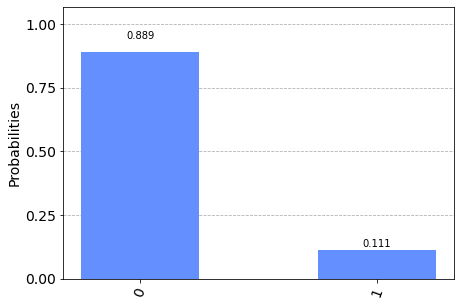

In [13]:
plot_histogram(answer)

In [14]:
answer

{'1': 114, '0': 910}

In [15]:
def calculate_overlap(answer):
    shots = answer['0'] if len(answer) == 1 else answer['0']+answer['1']
    return np.abs(answer['0']/shots - 0.5) * 2

In [16]:
calculate_overlap(answer)

0.77734375

In [17]:
def calculate_angle_diff(rot_a, rot_b):
    a = np.array([np.cos(rot_a), np.sin(rot_a)])
    b = np.array([np.cos(rot_b), np.sin(rot_b)])
    return np.linalg.norm(a-b)

In [18]:
# caluclate overlaps for different qubit rotations
angle_diffs = []
overlaps = []
rotations = []
m = 50
for rot_a in np.linspace(-np.pi,np.pi,m):
    for rot_b in np.linspace(-np.pi,np.pi,m):
        _, answer = swap_test_basic(rot_a,rot_b)
        overlap = calculate_overlap(answer)
        rotations.append((rot_a, rot_b))
        angle_diffs.append(calculate_angle_diff(rot_a, rot_b))
        overlaps.append(overlap)

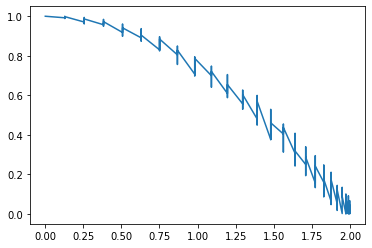

In [19]:
# plot results
angle_diffs_sorted, overlaps_sorted, rotations_sorted = zip(*sorted(zip(angle_diffs, overlaps, rotations)))
plt.plot(angle_diffs_sorted, overlaps_sorted)

In [20]:
print(np.array(overlaps_sorted) > 0.7)

[ True  True  True ... False False False]


In [21]:
high_overlap = np.array(rotations_sorted)[:3]

In [22]:
from qiskit.visualization import plot_bloch_multivector, plot_histogram
sim = Aer.get_backend('aer_simulator')
# Let's have U-gate transform a |0> to |+> state
qc = QuantumCircuit(2)
qc.u(high_overlap[2,0], 0, 0, 0)
qc.u(high_overlap[2,1], 0, 0, 1)
qc.draw()

┌────────────────┐
q_0: ┤ U(-2.8851,0,0) ├
     ├────────────────┤
q_1: ┤ U(-2.8851,0,0) ├
     └────────────────┘

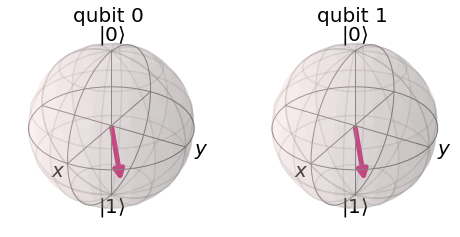

In [23]:
# Let's see the result
qc.save_statevector()
qobj = assemble(qc)
state = sim.run(qobj).result().get_statevector()
plot_bloch_multivector(state)

## basic amplitude encoded swap test

In [24]:
# basic swap test directly on quantum states that are rotated against each other
def swap_test_basic_amp_encoding(values_a, values_b):
    
    backend = Aer.get_backend('qasm_simulator')
    # create circuit with n qubits and one classical bit for measurement
    # qubits: first: ancilla, second: input vector, third: cluster center
    #(for latent space in R^2: 1 (ancilla) + 1 (x1,x2 coords of input) + 1 (x1,x2 coords of cluster))
    n = 2+1
    qc = QuantumCircuit(n, 1, name="swap_test")

    # control qubit default 0
    # load data first vector
    qc.initialize(values_a, 1)
    # rotate qubit b around x by rotate_b theta
    qc.initialize(values_b, 2)
    # third qubit init to phi
    qc.barrier()
    # apply hadamard to control
    qc.h(0)
    # swap psi ancilla with phi
    qc.cswap(0,1,2)
    # apply second hadamard
    qc.h(0)
    # measure control qubit
    qc.measure(0,0)
    qc.draw()
    
    shots = 1024
    qobj = assemble(qc, backend)
    results = backend.run(qobj).result()
    answer = results.get_counts()

    return qc, answer

In [25]:
a = np.array([10., 1])
b = np.array([0.1, 1.1])
# amplitude enoded
a_q = calc_amplitudes(a)
b_q = calc_amplitudes(b)

In [26]:
print(a_q)
print(b_q)

[0.99503719 0.09950372]
[0.09053575 0.99589321]


In [27]:
qc, answer = swap_test_basic_amp_encoding(a_q, b_q)

In [28]:
qc.draw()

░ ┌───┐   ┌───┐┌─┐
q_0: ─────────────────────────────────░─┤ H ├─■─┤ H ├┤M├
     ┌──────────────────────────────┐ ░ └───┘ │ └───┘└╥┘
q_1: ┤ Initialize(0.99504,0.099504) ├─░───────X───────╫─
     ├──────────────────────────────┤ ░       │       ║ 
q_2: ┤ Initialize(0.090536,0.99589) ├─░───────X───────╫─
     └──────────────────────────────┘ ░               ║ 
c: 1/═════════════════════════════════════════════════╩═
                                                      0

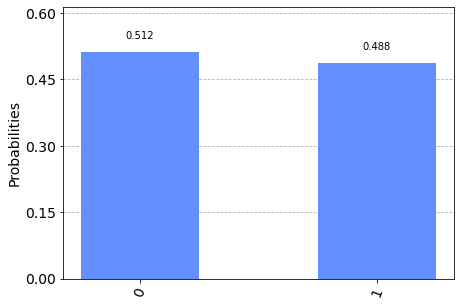

In [29]:
plot_histogram(answer)

In [30]:
answer

{'0': 524, '1': 500}

In [31]:
# caluclate overlaps for different qubit rotations
dist_eucl = []
overlaps = []
vectors = []
for i in range(15):
        a = calc_amplitudes(np.random.uniform(low=-2.3, high=2.3, size=2))
        b = calc_amplitudes(np.random.uniform(low=-2.3, high=2.3, size=2))
        _, answer = swap_test_basic_amp_encoding(a, b)
        overlap = calculate_overlap(answer)
        dist_eucl.append(np.linalg.norm(a-b))
        overlaps.append(overlap)
        vectors.append((a,b))

Text(0, 0.5, 'overlap')

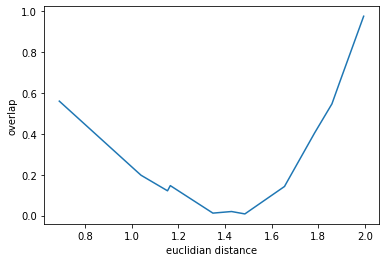

In [32]:
# plot results
dist_eucl_sorted, overlaps_sorted, vectors_sorted = zip(*sorted(zip(dist_eucl, overlaps, vectors)))
plt.plot(dist_eucl_sorted, overlaps_sorted)
plt.xlabel('euclidian distance')
plt.ylabel('overlap')

In [33]:
np.array(overlaps_sorted) > 0.7

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True])

In [34]:
high_overlap = np.array(vectors_sorted)[-3:]
print(high_overlap)

[[[-0.86387024 -0.50371441]
  [ 0.28289709  0.95915027]]

 [[ 0.8490765   0.5282699 ]
  [-0.99418167  0.10771629]]

 [[-0.54887928 -0.83590163]
  [ 0.42603844  0.90470506]]]


0.9999999999999999
0.9999999999999999
[-0.97491773 -1.74060669]
1.995037898377742


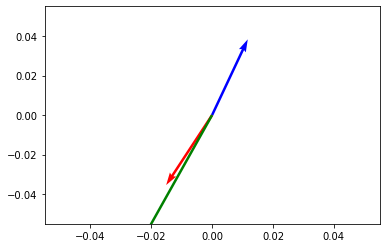

In [35]:
a = np.array(high_overlap[-1,0])
b = np.array(high_overlap[-1,1])
plt.quiver([0,0,0], [0,0,0], [a[0], b[0], (a-b)[0]], [a[1], b[1], (a-b)[1]], color=['r','b','g'], scale=4)
print(np.linalg.norm(b))
print(np.linalg.norm(b))
print(a-b)
print(np.linalg.norm(a-b))

# amplitude encoded ancilla swap test

In [78]:
# caluclate overlaps for different input vectors
dist_eucl = []
inner_prod_eucl = []
overlaps = []
vectors = []
dist_overlap = []
min_max_val = 1
for i in range(100):
        a = np.random.uniform(low=-min_max_val, high=min_max_val, size=2)
        b = np.random.uniform(low=-min_max_val, high=min_max_val, size=2)
        psi, phi, Z = prepare_swap_state_amplitudes(a, b)
        _, answer = swap_test(phi, psi)
        overlap = calculate_overlap(answer)
        dist_eucl.append(np.linalg.norm(a-b))
        inner_prod_eucl.append(np.dot(a,b))
        overlaps.append(overlap)
        vectors.append((a,b))
        dist_overlap.append(np.abs(overlap)**2 * 2 * Z)

Text(0, 0.5, 'quantum overlap')

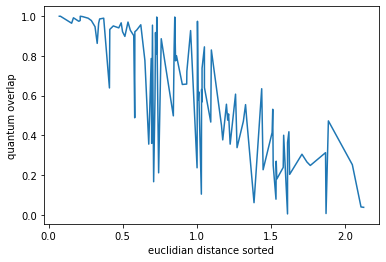

In [79]:
# plot results
dist_eucl_sorted, overlaps_sorted, vectors_sorted, dist_over_sorted, inner_prod_sorted = zip(*sorted(zip(dist_eucl, overlaps, vectors, dist_overlap, inner_prod_eucl)))
plt.plot(dist_eucl_sorted, overlaps_sorted)
plt.xlabel('euclidian distance sorted')
plt.ylabel('quantum overlap')

In [112]:
np.abs(overlaps_sorted)**2

array([1.37329102e-02, 3.08990479e-02, 3.81469727e-06, 3.73878479e-02,
       3.43322754e-03, 2.08892822e-02, 2.75611877e-02, 1.81617737e-02,
       3.66363525e-02, 1.36264801e-01])